In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import tensorflow.keras.layers as L

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split, KFold, RepeatedStratifiedKFold, StratifiedKFold
from transformers import BertTokenizer, TFBertModel, BertConfig, BertModel, TFDistilBertModel, DistilBertConfig

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
def seed_everything(seed = 34):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything()

In [3]:
train = pd.read_json('../input/stanford-covid-vaccine/train.json', lines=True)
test = pd.read_json('../input/stanford-covid-vaccine/test.json', lines=True)
sub = pd.read_csv('../input/stanford-covid-vaccine/sample_submission.csv')

#target columns
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [4]:
def MCRMSE(y_true, y_pred):
    columnwise_mse = tf.reduce_mean(tf.square(y_true-y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(columnwise_mse), axis=1)


In [5]:
AUTO = tf.data.experimental.AUTOTUNE

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [6]:
config = DistilBertConfig() 


In [7]:
config.vocab_size = 10
config.dim = 128
config.hidden_dim = 128
config.max_position_embeddings = 128
config.n_layers = 2
config.n_heads = 1
config.sinusoidal_pos_embds = True

In [8]:
def gru_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.GRU(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer = 'orthogonal'))

def lstm_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer = 'orthogonal'))

In [41]:
# lr = 1e-3
# max_grad_norm = 1.0
# num_training_steps = 1000
# num_warmup_steps = 100
# warmup_proportion = float(num_warmup_steps) / float(num_training_steps)  # 0.1
# optimizer = BertAdam(model.parameters(), lr=lr, schedule='warmup_linear', warmup=warmup_proportion, num_training_steps=100)

In [60]:
def build_model(transformer, seq_len=107, pred_len=68, dropout=0.5, embed_dim=100, hidden_dim=128):
    ids = L.Input(shape=(seq_len,3),  dtype=tf.int32, name="input_word_ids")
    flat = L.Flatten()(ids)
    sequence_output = transformer(flat)[0]
    
    truncated = sequence_output[:,:pred_len, :]
    
    out = L.Dense(32, activation='relu')(truncated)

    out = L.Dense(5, activation='linear')(out)
    model = tf.keras.Model(inputs=ids, outputs=out)

    model.compile('adam', loss=MCRMSE)
    
    return model

In [61]:
with strategy.scope():
    transformer_layer = (
        TFDistilBertModel(config=config)
    )
    model = build_model(transformer_layer)
model.summary()


Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 107, 3)]          0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 321)               0         
_________________________________________________________________
tf_distil_bert_model_5 (TFDi ((None, 321, 128),)       217088    
_________________________________________________________________
tf_op_layer_strided_slice_29 [(None, 68, 128)]         0         
_________________________________________________________________
dense_33 (Dense)             (None, 68, 32)            4128      
_________________________________________________________________
dense_34 (Dense)             (None, 68, 5)             165       
Total params: 221,381
Trainable params: 221,381
Non-trainable params: 0
____________________________________________________

In [62]:
tokentoint = {x:i for i, x in enumerate('().ACGUBEHIMSX')}
def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    return np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [tokentoint[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )
preprocess_inputs(train).shape

(2400, 107, 3)

In [63]:
train_inputs = preprocess_inputs(train[train['signal_to_noise'] >= 1])
train_labels = np.array(train[train['signal_to_noise'] >= 1][target_cols].values.tolist()).transpose(0, 2, 1)


In [64]:
print(train_inputs.shape)
print(train_labels.shape)


(2097, 107, 3)
(2097, 68, 5)


In [65]:
public_df = test[test['seq_length']==107].copy()
private_df = test[test['seq_length']==130].copy()

public_inputs = preprocess_inputs(public_df)
private_inputs = preprocess_inputs(private_df)


In [66]:
#basic training configuration
FOLDS = 5
EPOCHS = 70
REPEATS = 1
BATCH_SIZE = 64
VERBOSE = 2
SEED = 34


In [67]:
from sklearn.model_selection import KFold
lr_callback = tf.keras.callbacks.ReduceLROnPlateau()

In [68]:
bert_histories = []
bert_private_preds = np.zeros((private_df.shape[0], 130, 5))
bert_public_preds = np.zeros((public_df.shape[0], 107, 5))

kf = KFold(n_splits=FOLDS,shuffle=True,random_state=42)


with strategy.scope():
   
    
    for fold, (train_index, val_index) in enumerate(kf.split(train_inputs, train_labels)):
        print(f"FOLD {fold}")
        
        model = build_model(transformer_layer)
        
        history = model.fit(
            train_inputs[train_index,:,:], train_labels[train_index,:,:], 
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_split=0.1,
                callbacks=[
                            lr_callback,
                            tf.keras.callbacks.ModelCheckpoint('model'+str(fold)+'.h5',save_weights_only=True,save_best_only=True)
                            ])

        model_short = build_model(transformer_layer,seq_len=107, pred_len=107)
        model_long = build_model(transformer_layer,seq_len=130, pred_len=130)

        model_short.load_weights('model'+str(fold)+'.h5')
        model_long.load_weights('model'+str(fold)+'.h5')
        
        bert_histories.append(history)

        bert_public_pred = model_short.predict(public_inputs) / FOLDS

        bert_private_pred = model_long.predict(private_inputs) / FOLDS

        bert_public_preds += bert_public_pred
        bert_private_preds += bert_private_pred
        


FOLD 0
Epoch 1/70
24/24 [==============================] - 6s 256ms/step - loss: 0.5619 - val_loss: 0.4312 - lr: 0.0010
Epoch 2/70
24/24 [==============================] - 1s 34ms/step - loss: 0.4160 - val_loss: 0.4201 - lr: 0.0010
Epoch 3/70
24/24 [==============================] - 1s 33ms/step - loss: 0.4093 - val_loss: 0.4199 - lr: 0.0010
Epoch 4/70
24/24 [==============================] - 1s 34ms/step - loss: 0.4075 - val_loss: 0.4143 - lr: 0.0010
Epoch 5/70
24/24 [==============================] - 1s 34ms/step - loss: 0.4047 - val_loss: 0.4119 - lr: 0.0010
Epoch 6/70
24/24 [==============================] - 1s 35ms/step - loss: 0.4028 - val_loss: 0.4099 - lr: 0.0010
Epoch 7/70
24/24 [==============================] - 1s 31ms/step - loss: 0.4004 - val_loss: 0.4111 - lr: 0.0010
Epoch 8/70
24/24 [==============================] - 1s 30ms/step - loss: 0.3999 - val_loss: 0.4146 - lr: 0.0010
Epoch 9/70
24/24 [==============================] - 1s 35ms/step - loss: 0.3996 - val_loss: 0.40

24/24 [==============================] - 1s 36ms/step - loss: 0.3757 - val_loss: 0.3814 - lr: 0.0010
Epoch 4/70
24/24 [==============================] - 1s 37ms/step - loss: 0.3657 - val_loss: 0.3684 - lr: 0.0010
Epoch 5/70
24/24 [==============================] - 1s 38ms/step - loss: 0.3585 - val_loss: 0.3649 - lr: 0.0010
Epoch 6/70
24/24 [==============================] - 1s 38ms/step - loss: 0.3538 - val_loss: 0.3581 - lr: 0.0010
Epoch 7/70
24/24 [==============================] - 1s 33ms/step - loss: 0.3474 - val_loss: 0.3585 - lr: 0.0010
Epoch 8/70
24/24 [==============================] - 1s 38ms/step - loss: 0.3444 - val_loss: 0.3530 - lr: 0.0010
Epoch 9/70
24/24 [==============================] - 1s 38ms/step - loss: 0.3438 - val_loss: 0.3529 - lr: 0.0010
Epoch 10/70
24/24 [==============================] - 1s 31ms/step - loss: 0.3427 - val_loss: 0.3550 - lr: 0.0010
Epoch 11/70
24/24 [==============================] - 1s 38ms/step - loss: 0.3414 - val_loss: 0.3506 - lr: 0.0010
E

24/24 [==============================] - 1s 35ms/step - loss: 0.3344 - val_loss: 0.3433 - lr: 0.0010
Epoch 6/70
24/24 [==============================] - 1s 31ms/step - loss: 0.3304 - val_loss: 0.3475 - lr: 0.0010
Epoch 7/70
24/24 [==============================] - 1s 35ms/step - loss: 0.3277 - val_loss: 0.3382 - lr: 0.0010
Epoch 8/70
24/24 [==============================] - 1s 35ms/step - loss: 0.3240 - val_loss: 0.3345 - lr: 0.0010
Epoch 9/70
24/24 [==============================] - 1s 36ms/step - loss: 0.3224 - val_loss: 0.3324 - lr: 0.0010
Epoch 10/70
24/24 [==============================] - 1s 33ms/step - loss: 0.3212 - val_loss: 0.3325 - lr: 0.0010
Epoch 11/70
24/24 [==============================] - 1s 36ms/step - loss: 0.3207 - val_loss: 0.3297 - lr: 0.0010
Epoch 12/70
24/24 [==============================] - 1s 32ms/step - loss: 0.3206 - val_loss: 0.3320 - lr: 0.0010
Epoch 13/70
24/24 [==============================] - 1s 32ms/step - loss: 0.3197 - val_loss: 0.3369 - lr: 0.0010

24/24 [==============================] - 1s 36ms/step - loss: 0.3135 - val_loss: 0.3272 - lr: 0.0010
Epoch 8/70
24/24 [==============================] - 1s 31ms/step - loss: 0.3129 - val_loss: 0.3315 - lr: 0.0010
Epoch 9/70
24/24 [==============================] - 1s 32ms/step - loss: 0.3113 - val_loss: 0.3278 - lr: 0.0010
Epoch 10/70
24/24 [==============================] - 1s 33ms/step - loss: 0.3122 - val_loss: 0.3274 - lr: 0.0010
Epoch 11/70
24/24 [==============================] - 1s 36ms/step - loss: 0.3095 - val_loss: 0.3262 - lr: 0.0010
Epoch 12/70
24/24 [==============================] - 1s 37ms/step - loss: 0.3084 - val_loss: 0.3250 - lr: 0.0010
Epoch 13/70
24/24 [==============================] - 1s 36ms/step - loss: 0.3082 - val_loss: 0.3247 - lr: 0.0010
Epoch 14/70
24/24 [==============================] - 1s 35ms/step - loss: 0.3082 - val_loss: 0.3238 - lr: 0.0010
Epoch 15/70
24/24 [==============================] - 1s 30ms/step - loss: 0.3091 - val_loss: 0.3257 - lr: 0.00

24/24 [==============================] - 1s 30ms/step - loss: 0.3111 - val_loss: 0.3284 - lr: 0.0010
Epoch 9/70
24/24 [==============================] - 1s 30ms/step - loss: 0.3107 - val_loss: 0.3299 - lr: 0.0010
Epoch 10/70
24/24 [==============================] - 1s 30ms/step - loss: 0.3099 - val_loss: 0.3279 - lr: 0.0010
Epoch 11/70
24/24 [==============================] - 1s 31ms/step - loss: 0.3091 - val_loss: 0.3280 - lr: 0.0010
Epoch 12/70
24/24 [==============================] - 1s 36ms/step - loss: 0.3090 - val_loss: 0.3272 - lr: 0.0010
Epoch 13/70
24/24 [==============================] - 1s 31ms/step - loss: 0.3080 - val_loss: 0.3279 - lr: 0.0010
Epoch 14/70
24/24 [==============================] - 1s 38ms/step - loss: 0.3075 - val_loss: 0.3247 - lr: 0.0010
Epoch 15/70
24/24 [==============================] - 1s 32ms/step - loss: 0.3069 - val_loss: 0.3268 - lr: 0.0010
Epoch 16/70
24/24 [==============================] - 1s 36ms/step - loss: 0.3078 - val_loss: 0.3241 - lr: 0.0

In [69]:
loss = pd.DataFrame({ "loss": history.history['loss'], "val_loss": history.history['val_loss']})

In [70]:
history.history

{'loss': [0.6021100878715515,
  0.36736220121383667,
  0.3342948257923126,
  0.3205300569534302,
  0.31591367721557617,
  0.31333860754966736,
  0.31280264258384705,
  0.3111133575439453,
  0.3106634318828583,
  0.3098655045032501,
  0.30914419889450073,
  0.3090193271636963,
  0.3079523742198944,
  0.30750784277915955,
  0.3069045841693878,
  0.30783966183662415,
  0.3078019320964813,
  0.3075067698955536,
  0.30664005875587463,
  0.306295245885849,
  0.3056457042694092,
  0.305927574634552,
  0.30593788623809814,
  0.3062324523925781,
  0.3067706227302551,
  0.3063541650772095,
  0.30587038397789,
  0.3046576678752899,
  0.3056255877017975,
  0.3065192997455597,
  0.3055943548679352,
  0.3052004873752594,
  0.305929034948349,
  0.3049778938293457,
  0.3045072853565216,
  0.30440130829811096,
  0.30002036690711975,
  0.2992188036441803,
  0.29867100715637207,
  0.29874736070632935,
  0.29858896136283875,
  0.2981647551059723,
  0.29819434881210327,
  0.2979615032672882,
  0.2979165613

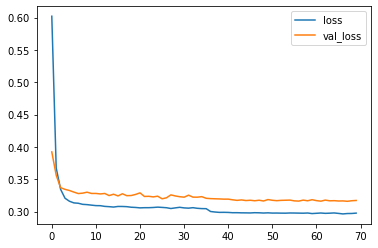

In [71]:
import matplotlib.pyplot as plt
loss.plot()

In [21]:
preds_bert = []

for df, preds in [(public_df, bert_public_preds), (private_df, bert_private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_bert.append(single_df)

preds_bert_df = pd.concat(preds_bert)
preds_bert_df.head()


,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.0,0.0,0.0,0.0,0.0,id_00073f8be_0
1,0.0,0.0,0.0,0.0,0.0,id_00073f8be_1
2,0.0,0.0,0.0,0.0,0.0,id_00073f8be_2
3,0.0,0.0,0.0,0.0,0.0,id_00073f8be_3
4,0.0,0.0,0.0,0.0,0.0,id_00073f8be_4


In [22]:
submission = sub[['id_seqpos']].merge(preds_bert_df, on=['id_seqpos'])
submission.to_csv('submission3.csv', index=False)